In [56]:
import networkx as nx
import dwave_networkx as dnx

from dqanneal.graph.embed import (get_problem_graph, 
                                  embed_problem_onto_hardware, 
                                  define_embedded_qubo_problem,
                                  unembed_samples,
                                  create_king_graph)
from dqanneal.solvers.solvers import dimod_optimizer_local, save_annealing_results

In [57]:
import dimod
import minorminer
import dwave # same as: dwave-ocean-sdk  
import dwaveoceansdk


print(dimod.__version__)
print(minorminer.__version__)
print(dwaveoceansdk.__version__)


0.12.18
0.2.16
8.1.0


# Define the QUBO problem

In [58]:
dwave_qubo = {
    (0, 0):  -1,
    (0, 1):   2,
    (0, 2):  -3,
    (0, 3):   4,
    (0, 4):  -5,
    (0, 5):   6,
    (0, 6):  -7,
    (0, 7):   8,
    (0, 8):  -9,
    (0, 9):   10,
    (0, 10): -11,
    (0, 11):  12,
    (0, 12): -13,
    (0, 13):  14,
    (0, 14): -15,
    (0, 15):  16,
    (0, 16): -17,
    (0, 17):  18,
    (0, 18): -19,
    (0, 19):  20,
    (0, 20): -21,
    (4, 16):  22,
    (1, 19): -23,
    }

In [59]:
source_bqm = dimod.BinaryQuadraticModel.from_qubo(dwave_qubo)
print(f'numbera of variables: {len(source_bqm.variables)}')

numbera of variables: 21


In [62]:
problem_graph, problem_edge_dict = get_problem_graph(dwave_qubo)
nx.get_edge_attributes(problem_graph, "bias")

{(0, 1): np.float64(2.0),
 (0, 2): np.float64(-3.0),
 (0, 3): np.float64(4.0),
 (0, 4): np.float64(-5.0),
 (0, 5): np.float64(6.0),
 (0, 6): np.float64(-7.0),
 (0, 7): np.float64(8.0),
 (0, 8): np.float64(-9.0),
 (0, 9): np.float64(10.0),
 (0, 10): np.float64(-11.0),
 (0, 11): np.float64(12.0),
 (0, 12): np.float64(-13.0),
 (0, 13): np.float64(14.0),
 (0, 14): np.float64(-15.0),
 (0, 15): np.float64(16.0),
 (0, 16): np.float64(-17.0),
 (0, 17): np.float64(18.0),
 (0, 18): np.float64(-19.0),
 (0, 19): np.float64(20.0),
 (0, 20): np.float64(-21.0),
 (1, 19): np.float64(-23.0),
 (4, 16): np.float64(22.0)}

# build a hardware graph

In [6]:
### need to setup dwave leap token access for this

# from dwave.system.samplers import DWaveSampler
# import networkx as nx
# sampler_dw = DWaveSampler(solver={'topology__type': 'pegasus'})
# G = nx.from_dict_of_lists(sampler_dw.adjacency)
# edge_dict = {node: set(G.neighbors(node)) for node in G.nodes}

In [7]:


# https://docs.ocean.dwavesys.com/en/latest/docs_dnx/reference/generators.html
# G = dnx.chimera_graph(1, 1, 4)
# G = dnx.zephyr_graph(6)

# https://github.com/dwave-examples/pegasus-notebook/blob/master/01-exploring-pegasus.ipynb
hardware_graph = dnx.pegasus_graph(16)
hardware_graph_edge_dict = {node: set(hardware_graph.neighbors(node)) for node in hardware_graph.nodes}

Text(0.5, 1.0, 'King Graph')

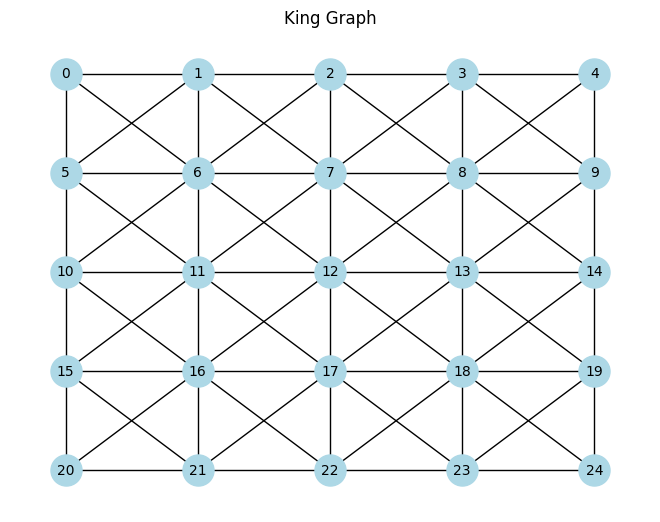

In [8]:
import matplotlib.pyplot as plt

hardware_graph, hardware_graph_edge_dict, pos = create_king_graph(5,5)

nx.draw(hardware_graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("King Graph")

# embed given problem onto hardware graph

In [9]:
embedded_problem, valid_flag = embed_problem_onto_hardware(problem_graph,
                                                            hardware_graph,
                                                            maxtime_sec=40,
                                                            attempts=10)

In [10]:
print(f'Was successful: {bool(valid_flag)}')

Was successful: True


In [11]:
dwave.embedding.verify_embedding(embedded_problem,
                                 problem_graph,
                                 hardware_graph)

True

In [12]:
embedded_problem

{0: [12, 18, 8, 6, 16],
 1: [7],
 2: [24],
 3: [19],
 4: [14],
 5: [20],
 6: [17],
 7: [2],
 8: [15],
 9: [5],
 10: [3],
 11: [21],
 12: [0],
 13: [13],
 14: [11],
 15: [4],
 16: [9],
 17: [10],
 18: [22],
 19: [1],
 20: [23]}

In [13]:
embedded_qubo, convert_fn_sample = define_embedded_qubo_problem(
                                    embedded_problem,
                                    hardware_graph_edge_dict,
                                    dwave_qubo)

In [14]:
embedded_bqm = dimod.BinaryQuadraticModel.from_qubo(embedded_qubo)
print(f'number of variables: {len(embedded_bqm.variables)}')

number of variables: 25


# run solver on embedded problem

In [15]:
### chain strength
# https://arxiv.org/pdf/2007.01730
# https://dwave-systemdocs.readthedocs.io/en/master/reference/embedding.html

from dwave.embedding.chain_strength import uniform_torque_compensation, scaled

chain_strength = scaled(source_bqm, embedding=embedded_bqm, prefactor=1.414)
chain_strength = uniform_torque_compensation(source_bqm, embedding=embedded_bqm, prefactor=1.414)
chain_strength

28.69111179442163

In [16]:
optimizer = dimod_optimizer_local(optimizer_type='ExactSolver')
embedded_sampleset, embedded_best_sample = optimizer.sample_qubo(embedded_qubo, 1, chain_strength=chain_strength)

/Users/lex/anaconda3/envs/dwave310/lib/python3.10/site-packages/dimod/core/sampler.py:292: SamplerUnknownArgWarning: Ignoring unknown kwarg: 'num_reads'
  return self.sample(bqm, **parameters)
/Users/lex/anaconda3/envs/dwave310/lib/python3.10/site-packages/dimod/core/sampler.py:292: SamplerUnknownArgWarning: Ignoring unknown kwarg: 'chain_strength'
  return self.sample(bqm, **parameters)


In [22]:
optimizer2 = dimod_optimizer_local(optimizer_type='SimulatedAnnealing')
embedded_sampleset2, embedded_best_sample2 = optimizer2.sample_qubo(embedded_qubo,
                                                                    1_000,
                                                                    chain_strength=chain_strength)

In [27]:
embedded_sampleset

SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0. , 1),
           ([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1.8, 1),
           ([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 5.6, 1),
           ...,
           ([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 5.6, 1),
           ([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 1.8, 1),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 0. , 1)],
          dtype=[('sample', 'i1', (25,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), Variables(range(0, 25)), {}, 'BINARY')

# Convert output into original problem form

In [23]:
unembedded_samples, unembedded_best = unembed_samples(embedded_sampleset,
                                    embedded_problem, 
                                    source_bqm)
unembedded_samples

SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0., 1),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0., 1),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0., 1),
           ...,
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0., 1),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0., 1),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0., 1)],
          dtype=[('sample', 'i1', (21,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), Variables(range(0, 21)), {}, 'BINARY')

In [24]:
source_bqm.energy(unembedded_best)

np.float64(-117.0)

# check against exact answer:

In [41]:
solver = dimod.ExactSolver()
out = dimod.ExactSolver().sample_qubo(dwave_qubo)
source_bqm.energy(out.first.sample)

np.float64(-117.0)

In [42]:
embedded_bqm.energy(embedded_best_sample)

np.float64(-117.46666666666667)

In [ ]:
# dimod.BinaryQuadraticModel.from_serializable(source_bqm.to_serializable())

# save output

Extra data added to seperate dict:
- the parent BQM
- the embedded problem
- problem_graph
- hardware_graph

In [65]:
# nx.to_dict_of_dicts(problem_graph)

In [ ]:
extra_dictionary = {
    'source_bqm'      : source_bqm.to_serializable(),
    'embedded_bqm'    : embedded_bqm.to_serializable(),
    # 'embedded_qubo'   : embedded_qubo,
    # 'dwave_qubo'      : dwave_qubo,
    
    'embedded_problem': embedded_problem,
    'problem_graph'   : nx.adjacency_matrix(problem_graph, weight='bias').todense().tolist(),
    'hardware_graph'  : nx.adjacency_matrix(hardware_graph, weight='bias').todense().tolist(),
    
        }

In [ ]:
output_file_path = save_annealing_results(embedded_sampleset,
                        extra_ending='test',
                        verbose=False,
                        extra_dictionary=extra_dictionary,
                        zip_data=True)